# The Wong-Wang Decision-Making Model

A biophysically-inspired neural mass model for perceptual decision-making and evidence integration.

## Learning Objectives

By the end of this tutorial, you will be able to:

- Understand the biophysical basis of the Wong-Wang model (NMDA synaptic dynamics)
- Simulate two-choice decision-making with varying stimulus coherence
- Analyze decision accuracy, reaction time, and choice probability
- Explain the attractor dynamics underlying perceptual decisions

## Background / Theory

### The Decision-Making Problem

When you see dots moving on a screen, how does your brain decide whether they're moving left or right? This is the classic **random dot motion task** studied extensively in neuroscience.

Key experimental findings:
- Decision accuracy increases with stimulus strength (coherence)
- Reaction time decreases with stimulus strength
- Neural activity in parietal cortex ramps up during decision formation

### The Wong-Wang Model

Wong & Wang (2006) developed a reduced neural mass model that captures these phenomena. The model describes two competing neural populations:

- **Population 1**: Prefers leftward motion
- **Population 2**: Prefers rightward motion

### Mathematical Formulation

The synaptic gating variables $S_1$ and $S_2$ evolve according to:

$$
\begin{aligned}
\frac{dS_1}{dt} &= -\frac{S_1}{\tau_S} + (1-S_1)\gamma r_1 \\
\frac{dS_2}{dt} &= -\frac{S_2}{\tau_S} + (1-S_2)\gamma r_2
\end{aligned}
$$

Where firing rates are computed from input currents via threshold-linear function:

$$
r_i = \phi(I_i) = \alpha(I_i - \theta)^+ 
$$

Input currents include:
- **Recurrent excitation**: $J_{N,11}S_1$ or $J_{N,22}S_2$
- **Cross-inhibition**: $-J_{N,12}S_2$ or $-J_{N,21}S_1$
- **Stimulus**: $J_{A,ext}\mu_0(1 \pm c)$ where $c$ is coherence

### Key Parameters

| Parameter | Value | Description |
|-----------|-------|-------------|
| $\tau_S$ | 100 ms | NMDA time constant (slow integration) |
| $\gamma$ | 0.641 | Saturation factor |
| $\alpha$ | 270 Hz/nA | Gain |
| $\theta$ | 0.31 nA | Firing threshold |
| $c$ | [-1, 1] | Motion coherence |

## Implementation

### Step 1: Setup and Imports

In [1]:
import brainmass
import brainstate
import brainunit as u
import matplotlib.pyplot as plt
import numpy as np

# Set simulation time step (finer for accurate dynamics)
brainstate.environ.set(dt=0.5 * u.ms)

### Step 2: Single Decision Trial

Let's simulate a single trial with moderate coherence:

In [2]:
# Create Wong-Wang model
model = brainmass.WongWangStep(
    in_size=1,  # single decision unit
    # Add noise for realistic variability
    noise_s1=brainmass.OUProcess(1, sigma=0.02 * u.nA, tau=2.0 * u.ms),
    noise_s2=brainmass.OUProcess(1, sigma=0.02 * u.nA, tau=2.0 * u.ms),
)

# Initialize states
model.init_all_states()

print(f"NMDA time constant: {model.tau_S.value()}")
print(f"Firing threshold: {model.theta.value()}")

NMDA time constant: 0.10000000149011612 * second
Firing threshold: 0.3100000023841858 * namp


In [3]:
# Simulate a trial with positive coherence (favoring population 1)
coherence = 0.25  # 25% motion coherence


def step_run(i):
    r1, r2 = model.update(coherence=coherence)
    return model.S1.value, model.S2.value, r1, r2


# Run for 2 seconds (typical decision time)
n_steps = int(2.0 * u.second / brainstate.environ.get_dt())
indices = np.arange(n_steps)
S1_trace, S2_trace, r1_trace, r2_trace = brainstate.transform.for_loop(step_run, indices)

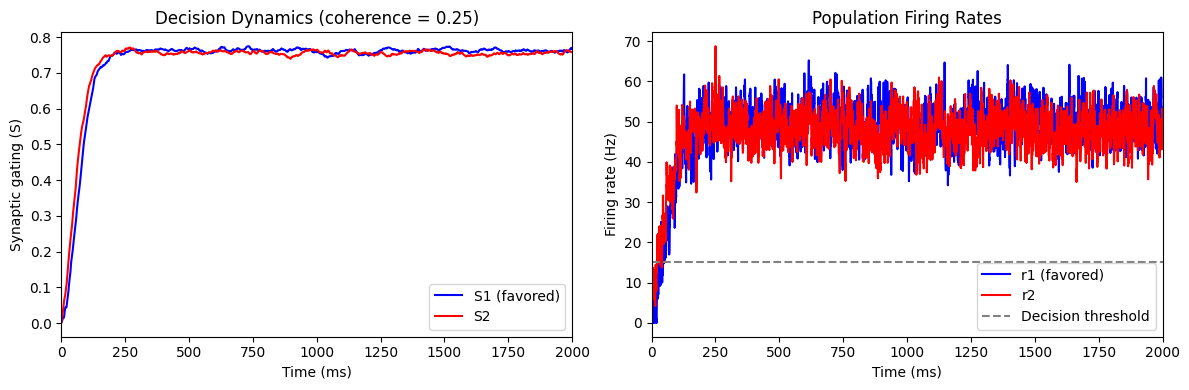

In [4]:
t_ms = indices * brainstate.environ.get_dt()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Synaptic gating variables
axes[0].plot(t_ms, S1_trace[:, 0], 'b-', label='S1 (favored)', linewidth=1.5)
axes[0].plot(t_ms, S2_trace[:, 0], 'r-', label='S2', linewidth=1.5)
axes[0].set_xlabel('Time (ms)')
axes[0].set_ylabel('Synaptic gating (S)')
axes[0].set_title(f'Decision Dynamics (coherence = {coherence})')
axes[0].legend()
axes[0].set_xlim([0, 2000])

# Firing rates
axes[1].plot(t_ms, r1_trace[:, 0], 'b-', label='r1 (favored)', linewidth=1.5)
axes[1].plot(t_ms, r2_trace[:, 0], 'r-', label='r2', linewidth=1.5)
axes[1].axhline(15, color='gray', linestyle='--', label='Decision threshold')
axes[1].set_xlabel('Time (ms)')
axes[1].set_ylabel('Firing rate (Hz)')
axes[1].set_title('Population Firing Rates')
axes[1].legend()
axes[1].set_xlim([0, 2000])

plt.tight_layout()
plt.show()

### Step 3: Effect of Stimulus Coherence

Coherence determines stimulus strength - let's see how it affects the decision:

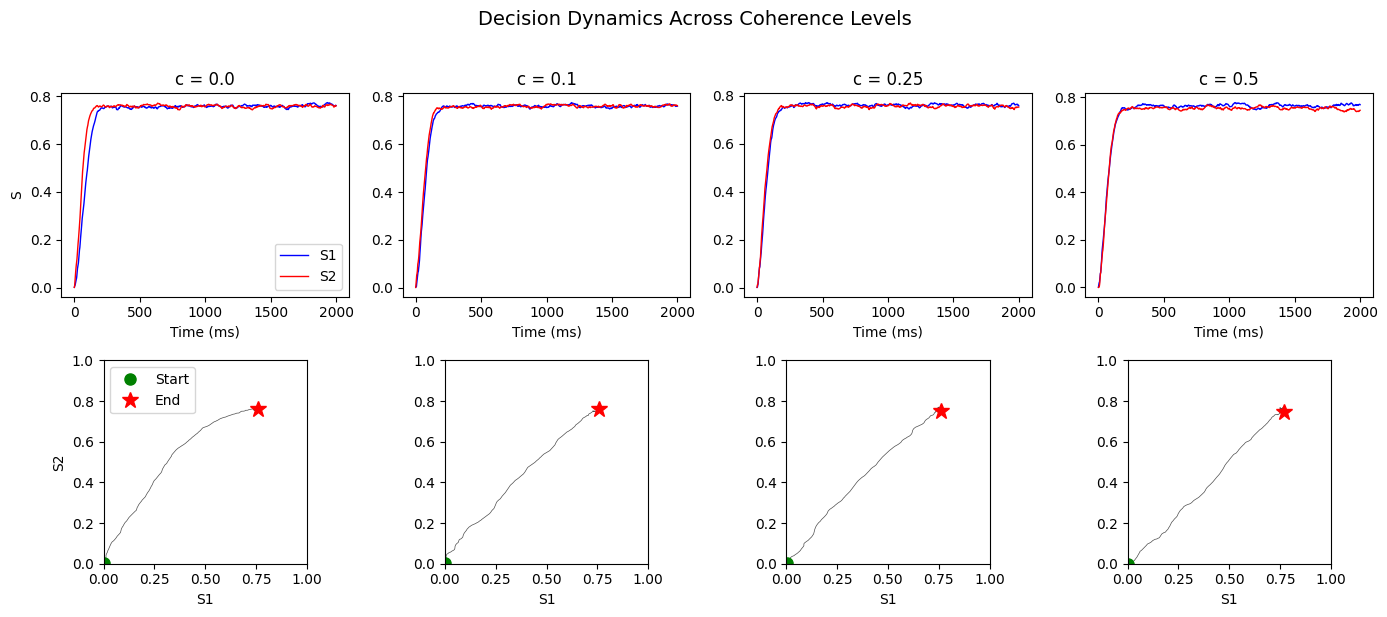

In [5]:
coherence_values = [0.0, 0.1, 0.25, 0.5]

fig, axes = plt.subplots(2, len(coherence_values), figsize=(14, 6))

for idx, coh in enumerate(coherence_values):
    # Create fresh model
    model = brainmass.WongWangStep(
        in_size=1,
        noise_s1=brainmass.OUProcess(1, sigma=0.02 * u.nA, tau=2.0 * u.ms),
        noise_s2=brainmass.OUProcess(1, sigma=0.02 * u.nA, tau=2.0 * u.ms),
    )
    model.init_all_states()


    # Simulate
    def step(i):
        r1, r2 = model.update(coherence=coh)
        return model.S1.value, model.S2.value


    S1, S2 = brainstate.transform.for_loop(step, indices)

    # Plot S dynamics (top row)
    axes[0, idx].plot(t_ms, S1[:, 0], 'b-', label='S1', linewidth=1)
    axes[0, idx].plot(t_ms, S2[:, 0], 'r-', label='S2', linewidth=1)
    axes[0, idx].set_title(f'c = {coh}')
    axes[0, idx].set_xlabel('Time (ms)')
    if idx == 0:
        axes[0, idx].set_ylabel('S')
        axes[0, idx].legend()

    # Phase portrait (bottom row)
    axes[1, idx].plot(S1[:, 0], S2[:, 0], 'k-', linewidth=0.5, alpha=0.7)
    axes[1, idx].plot(S1[0, 0], S2[0, 0], 'go', markersize=8, label='Start')
    axes[1, idx].plot(S1[-1, 0], S2[-1, 0], 'r*', markersize=12, label='End')
    axes[1, idx].set_xlabel('S1')
    if idx == 0:
        axes[1, idx].set_ylabel('S2')
        axes[1, idx].legend()
    axes[1, idx].set_xlim([0, 1])
    axes[1, idx].set_ylim([0, 1])
    axes[1, idx].set_aspect('equal')

plt.suptitle('Decision Dynamics Across Coherence Levels', y=1.02, fontsize=14)
plt.tight_layout()
plt.show()

### Step 4: Psychometric Function

Run multiple trials to measure choice accuracy as a function of coherence:

In [6]:
# Parameters
coherence_levels = np.array([-0.5, -0.25, -0.1, 0.0, 0.1, 0.25, 0.5])
n_trials = 20  # trials per coherence
decision_threshold = 0.5  # S value threshold


def single_trial(coh):
    # Fresh model each trial
    model = brainmass.WongWangStep(
        in_size=1,
        noise_s1=brainmass.OUProcess(1, sigma=0.02 * u.nA, tau=2.0 * u.ms),
        noise_s2=brainmass.OUProcess(1, sigma=0.02 * u.nA, tau=2.0 * u.ms),
    )
    model.init_all_states()

    # Simulate
    def step(i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            model.update(coherence=coh)
            return model.S1.value, model.S2.value

    brainstate.transform.for_loop(step, np.arange(int(1.5 * u.second / brainstate.environ.get_dt())))

    # Decision: which population won?
    choice = u.math.where(model.S1.value > model.S2.value, 1, 0)
    return choice


def multi_trials(coh):
    choices = brainstate.transform.vmap2(lambda: single_trial(coh), axis_size=n_trials)()
    return choices.mean()


@brainstate.transform.jit
def multi_coherences():
    return brainstate.transform.vmap2(multi_trials)(coherence_levels)


choice_prob = multi_coherences()

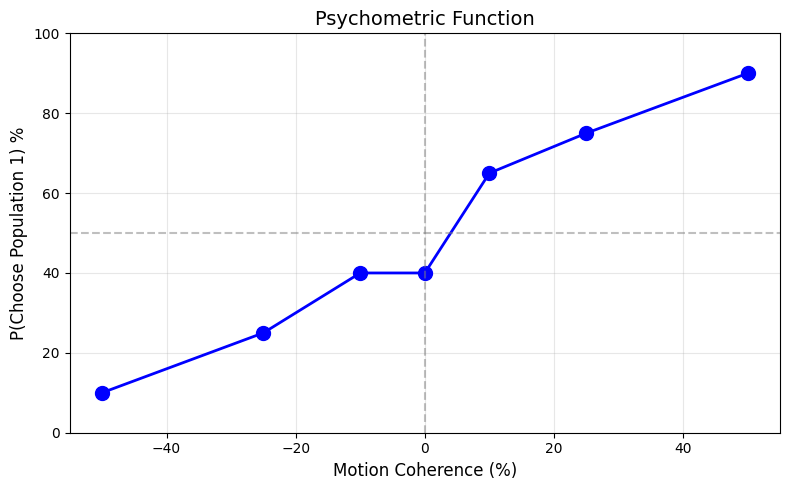

In [7]:
plt.figure(figsize=(8, 5))
plt.plot(coherence_levels * 100, choice_prob * 100, 'bo-', markersize=10, linewidth=2)
plt.axhline(50, color='gray', linestyle='--', alpha=0.5)
plt.axvline(0, color='gray', linestyle='--', alpha=0.5)

plt.xlabel('Motion Coherence (%)', fontsize=12)
plt.ylabel('P(Choose Population 1) %', fontsize=12)
plt.title('Psychometric Function', fontsize=14)
plt.ylim([0, 100])
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### Step 5: Attractor Dynamics

The Wong-Wang model exhibits bistable attractor dynamics. Let's visualize the attractor landscape:

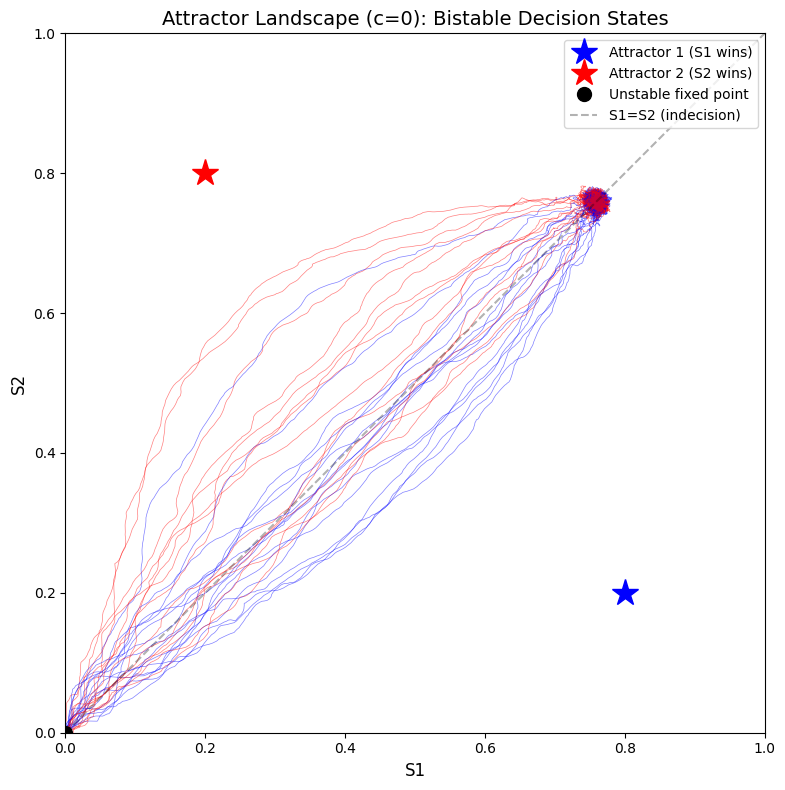

In [8]:
# Run many trials with zero coherence to see bistability
n_trials_attractor = 30
fig, ax = plt.subplots(figsize=(8, 8))

for trial in range(n_trials_attractor):
    model = brainmass.WongWangStep(
        in_size=1,
        noise_s1=brainmass.OUProcess(1, sigma=0.025 * u.nA, tau=2.0 * u.ms),
        noise_s2=brainmass.OUProcess(1, sigma=0.025 * u.nA, tau=2.0 * u.ms),
    )
    model.init_all_states()


    def step(i):
        with brainstate.environ.context(i=i, t=i * brainstate.environ.get_dt()):
            model.update(coherence=0.0)  # Zero coherence
            return model.S1.value, model.S2.value


    S1, S2 = brainstate.transform.for_loop(step, np.arange(int(2.0 * u.second / brainstate.environ.get_dt())))

    # Color by final choice
    color = 'blue' if S1[-1, 0] > S2[-1, 0] else 'red'
    ax.plot(S1[:, 0], S2[:, 0], color=color, linewidth=0.5, alpha=0.5)

# Mark attractors
ax.plot([0.8], [0.2], 'b*', markersize=20, label='Attractor 1 (S1 wins)')
ax.plot([0.2], [0.8], 'r*', markersize=20, label='Attractor 2 (S2 wins)')
ax.plot([0], [0], 'ko', markersize=10, label='Unstable fixed point')

# Diagonal
ax.plot([0, 1], [0, 1], 'k--', alpha=0.3, label='S1=S2 (indecision)')

ax.set_xlabel('S1', fontsize=12)
ax.set_ylabel('S2', fontsize=12)
ax.set_title('Attractor Landscape (c=0): Bistable Decision States', fontsize=14)
ax.legend(loc='upper right')
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

## Exercises

### Exercise 1: Reaction Time Analysis

Measure how long it takes to reach a decision:

```python
def measure_reaction_time(S1_trace, S2_trace, threshold=0.5):
    """Find when |S1 - S2| exceeds threshold."""
    diff = np.abs(S1_trace - S2_trace)
    crossing = np.where(diff > threshold)[0]
    return crossing[0] if len(crossing) > 0 else len(S1_trace)
```

Questions:
1. How does reaction time vary with coherence?
2. Plot reaction time vs coherence (chronometric function)

### Exercise 2: Speed-Accuracy Tradeoff

Explore how noise affects decision-making:
1. Increase noise sigma from 0.02 to 0.05 nA
2. What happens to accuracy? To reaction time?
3. Is there a speed-accuracy tradeoff?

### Exercise 3: Whole-Brain Decision Network

Create multiple interconnected decision units:

```python
# Multiple decision areas
model = brainmass.WongWangStep(in_size=10)  # 10 decision units
```

Add coupling between units and explore how network structure affects decision-making.

## Summary

In this tutorial, you learned:

1. **Wong-Wang model**: A biophysically-inspired model for perceptual decision-making
2. **NMDA dynamics**: Slow synaptic time constants enable temporal integration of evidence
3. **Coherence effects**: Stimulus strength determines accuracy and speed
4. **Attractor dynamics**: Decisions emerge from competition between bistable states

### Key Insights

- **Evidence integration**: The slow NMDA time constant ($\tau_S \approx$ 100ms) allows accumulation of noisy sensory evidence
- **Winner-take-all**: Cross-inhibition creates competition leading to a clear winner
- **Bistability**: At zero coherence, the system can settle into either attractor

### Neuroscience Connection

The model captures key features observed in monkey LIP neurons during random dot motion tasks:
- Ramping activity during decision formation
- Threshold crossing predicts choice and reaction time
- Psychometric and chronometric functions match behavior

## References

1. Wong, K.-F., & Wang, X.-J. (2006). A recurrent network mechanism of time integration in perceptual decisions. *Journal of Neuroscience*, 26(4), 1314-1328.

2. Gold, J. I., & Shadlen, M. N. (2007). The neural basis of decision making. *Annual Review of Neuroscience*, 30, 535-574.

3. Shadlen, M. N., & Newsome, W. T. (2001). Neural basis of a perceptual decision in the parietal cortex (area LIP) of the rhesus monkey. *Journal of Neurophysiology*, 86(4), 1916-1936.
